In [1]:
# read data: 30 ICs 
import nipype.interfaces.io as nio
import os
PD_ICA_file='/templateflow/PD_ICAs';
ICs_list=list(range(30))
ICs_list=["{:0>4d}".format(x) for x in ICs_list]
# file import
ds_ic = nio.DataGrabber(infields=['IC_id'])
ds_ic.inputs.base_directory = PD_ICA_file # database
ds_ic.inputs.template = 'melodic_IC_%4s.nii.gz' # from cwd
ds_ic.inputs.sort_filelist = True
ds_ic.inputs.IC_id = ICs_list
res_ic = ds_ic.run()
ic_list=res_ic.outputs.outfiles

200920-22:57:45,582 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0


In [2]:
import os
import nibabel as nib
from nilearn.image import resample_to_img
from nilearn.image import math_img
import numpy as np
from scipy import stats

ICA_AD_PATH ='/output/PPMI_DBM_AD/'
ICA_AD_sub_PATH ='/output/PPMI_DBM_AD/sub_dbm/'

if not os.path.exists(ICA_AD_PATH):
    os.makedirs(ICA_AD_PATH)
merged_file = ICA_AD_PATH+'reshape_merged_dbm3_masked.nii'
sub_list_file = ICA_AD_PATH+'subject_IDs.csv'

merged_img=nib.load(merged_file)
N_sub = merged_img.shape[3]

i_PD_IC=0
import nibabel as nib
PD_ICA_img=nib.load(ic_list[i_PD_IC]);
corr_list=[]

for i_sub in range(N_sub):
    #print(str(i_sub))
    sub_img = merged_img.slicer[:,:,:,i_sub]
    #sub_img_re = resample_to_img(sub_img, PD_ICA_img)
    #nib.save(sub_img, ICA_AD_sub_PATH+'sub-'+str(i_sub)+'_dbm.nii.gz')
    # n
    ic_data = PD_ICA_img.get_fdata().reshape(-1);
    sub_dat = sub_img.get_fdata().reshape(-1);
    nz_pos=np.flatnonzero(ic_data)
    ic_val =list(ic_data.ravel()[nz_pos])
    sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
    corr_list.append(np.corrcoef(ic_val, sub_val)[0,1])

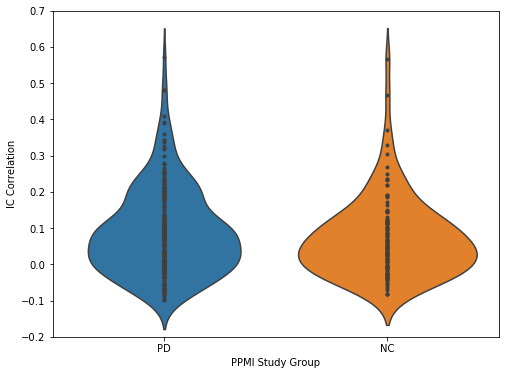

In [6]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sub_list =  pd.read_csv(sub_list_file, sep=',', header=0, index_col=0)
len(sub_list)
sub_label= ['PD' if x==1 else 'NC' for x in list(sub_list['PD'])]
ad_group_corr=pd.DataFrame({'IC Correlation': corr_list, 'PPMI Study Group': sub_label})
plt.figure(1, figsize=(8, 6))
ax = sns.violinplot(x="PPMI Study Group", y="IC Correlation", data=ad_group_corr, inner='point', )
#plt.ylim(-0.35, 0.35)
plt.ylim(-0.2, 0.7)
plt.savefig('ad_group_corr_ic0.png')

In [11]:
# MELODIC ICA (AD pd+nc Jacobian masked)
import time
from nipype.interfaces import fsl
from nipype.interfaces.ants import ANTS, ApplyTransforms,CreateJacobianDeterminantImage

ICA_AD_ICA_PATH ='/output/PPMI_DBM_AD/AD-ICA/'
if not os.path.exists(ICA_AD_ICA_PATH):
    os.makedirs(ICA_AD_ICA_PATH)
merged_file = ICA_AD_PATH+'reshape_merged_dbm3_masked.nii'
t0=time.time()
melodic_setup = fsl.MELODIC()
melodic_setup.inputs.approach = 'tica'
melodic_setup.inputs.in_files = [merged_file]
melodic_setup.inputs.no_bet = True
#melodic_setup.inputs.bg_threshold = 10
#melodic_setup.inputs.tr_sec = 1.5
#melodic_setup.inputs.mm_thresh = 0.5
#melodic_setup.inputs.out_stats = True
melodic_setup.inputs.out_all = True
#melodic_setup.inputs.num_ICs = 30
melodic_setup.inputs.out_pca = True
#melodic_setup.inputs.t_des = 'timeDesign.mat'resICA
#melodic_setup.inputs.t_con = 'timeDesign.con'
#melodic_setup.inputs.s_des = 'subjectDesign.mat'
#melodic_setup.inputs.s_con = 'subjectDesign.con'
melodic_setup.inputs.out_dir = ICA_AD_ICA_PATH
melodic_setup.inputs.report = True
melodic_setup.cmdline
melodic_setup.run()
print('\tAD MELODIC ICA takes: ', time.time()-t0)

	AD MELODIC ICA takes:  1419.4145150184631
